In [1]:
%matplotlib inline
import math
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

In [2]:
def show(images) :
    if type(images) is np.ndarray:
        images = [images]
    l = len(images)
    fig = plt.figure()
    fig.set_size_inches(20,20)
    for i,image in enumerate(images):
        fig.add_subplot(1, l, i+1)
        if len(image.shape) == 3:
            b,g,r = cv2.split(image)
            plt.imshow(cv2.merge((r,g,b)))
        else:
            plt.imshow(image, cmap='Greys')
          
    plt.show()


In [3]:
im = cv2.imread('input/red_barrels_3.png')

#cap = cv2.VideoCapture('videos/video1.mp4')
#cap.set(2,0.3)
#ret, frame = cap.read()
#show(frame)
#im = frame

In [4]:
def split_up(min,max,ticks):
    return [int(min + (max-min) * i / float(ticks)) for i in range(ticks+1)]

In [5]:
vanishing_point_xy = (718,270)

In [6]:
def draw_vanishing_lines(im):
    im_h, im_w, _ = im.shape
    radius = 10
    thickness = 3

    color = (255,50,50,100)

    im = cv2.circle(im,vanishing_point_xy,radius,color)

    for x in split_up(0-5000,im_w+5000,ticks=30):
      cv2.line(im, (x,im_h), vanishing_point_xy, color)


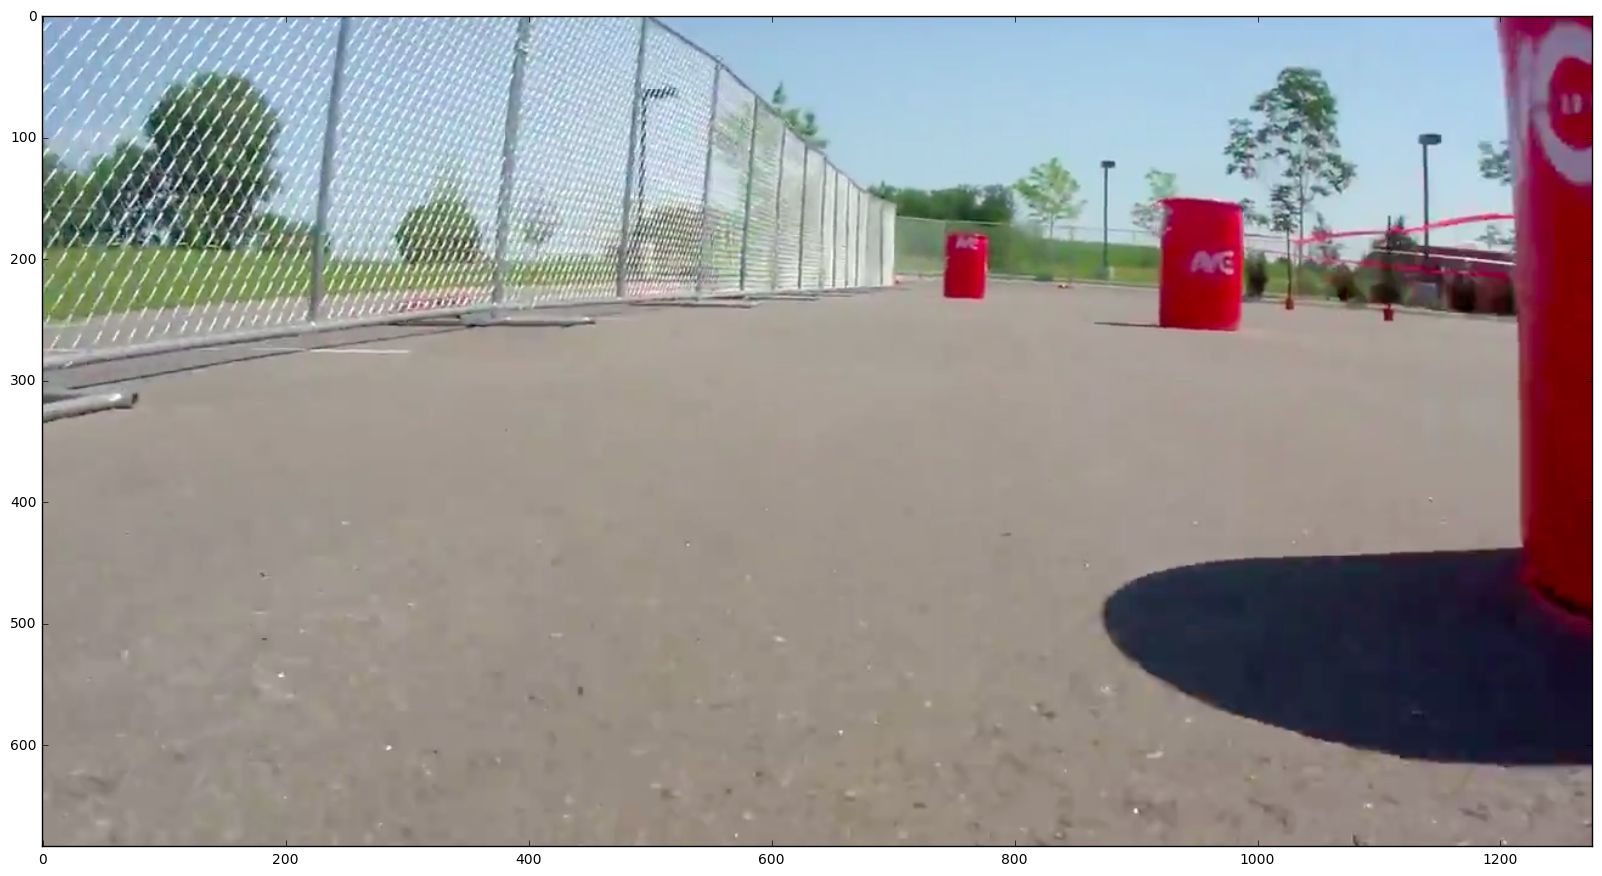

In [7]:
show(im)

In [8]:
im=cv2.blur(im,(15,15))

In [9]:
# based on https://stackoverflow.com/a/30333177/383967
def get_red_mask(img):
    img_hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # lower mask (0-10)
    lower_red = np.array([0,50,50])
    upper_red = np.array([10,255,255])
    mask0 = cv2.inRange(img_hsv, lower_red, upper_red)

    # upper mask (170-180)
    lower_red = np.array([170,50,50])
    upper_red = np.array([180,255,255])
    mask1 = cv2.inRange(img_hsv, lower_red, upper_red)

    # join masks
    mask = np.invert(mask0+mask1)
    
    return mask



In [10]:
def mask_image(img, mask):
    output_img = img.copy()
    output_img[np.where(mask==0)] = 0
    return output_img


In [11]:
def find_red(img):
    return mask_image(img, get_red_mask(img))


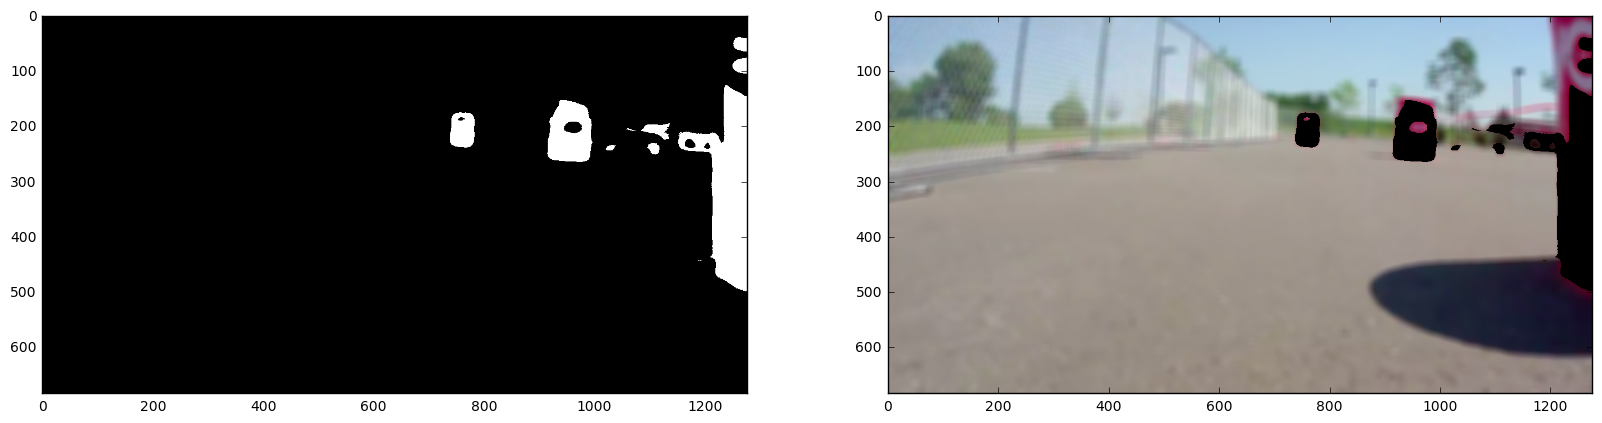

In [12]:
im_mask = get_red_mask(im)
im_red = find_red(im)
show([im_mask, im_red])


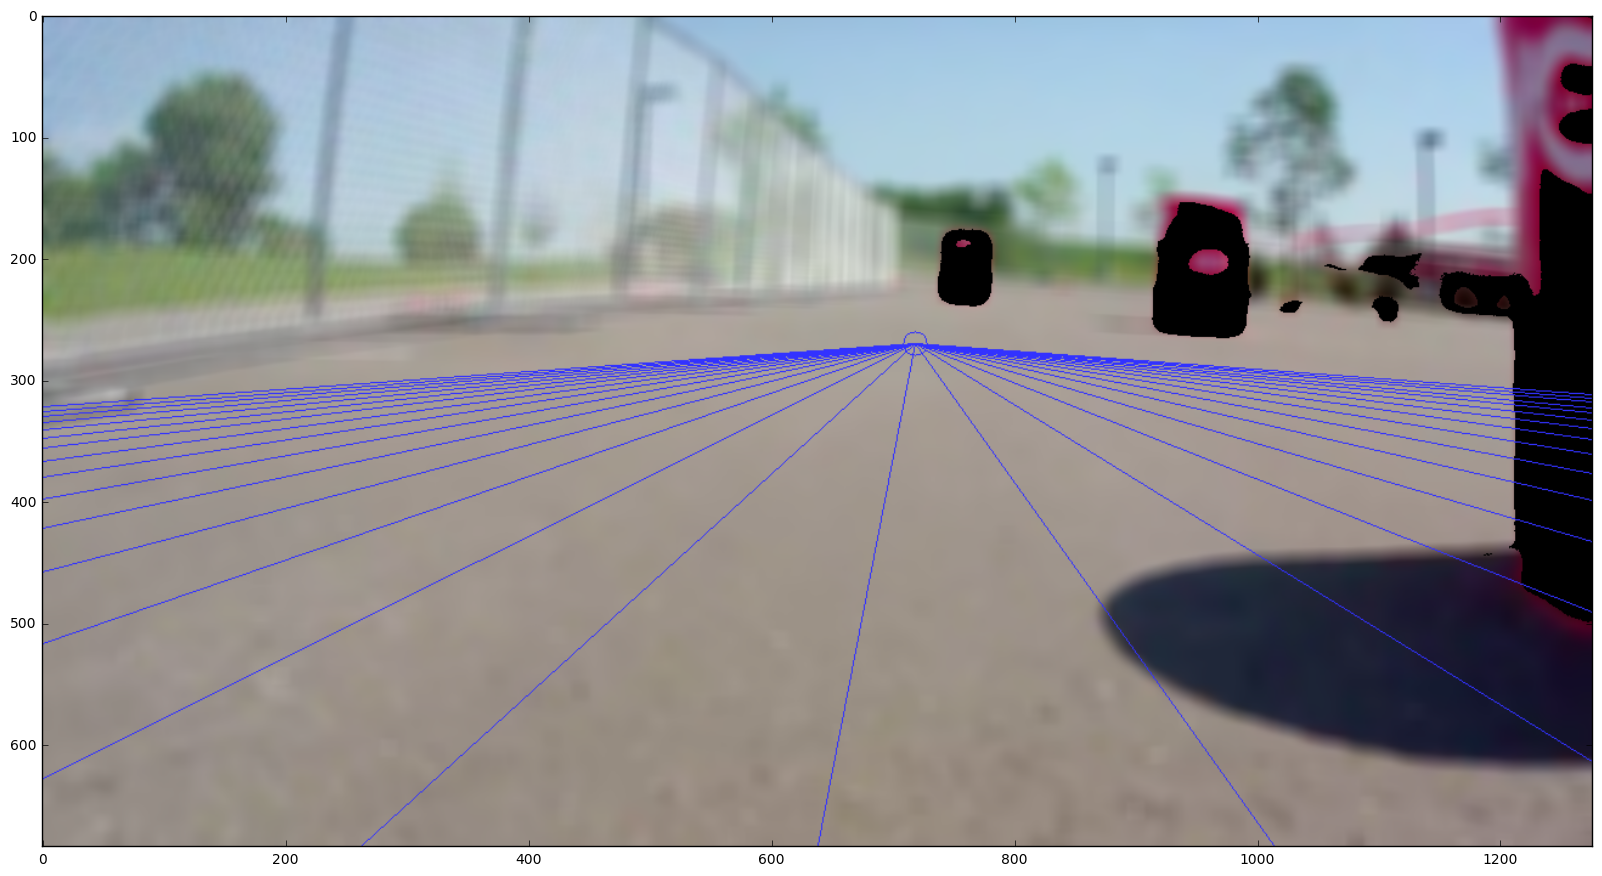

In [13]:
draw_vanishing_lines(im_red)
show([im_red])

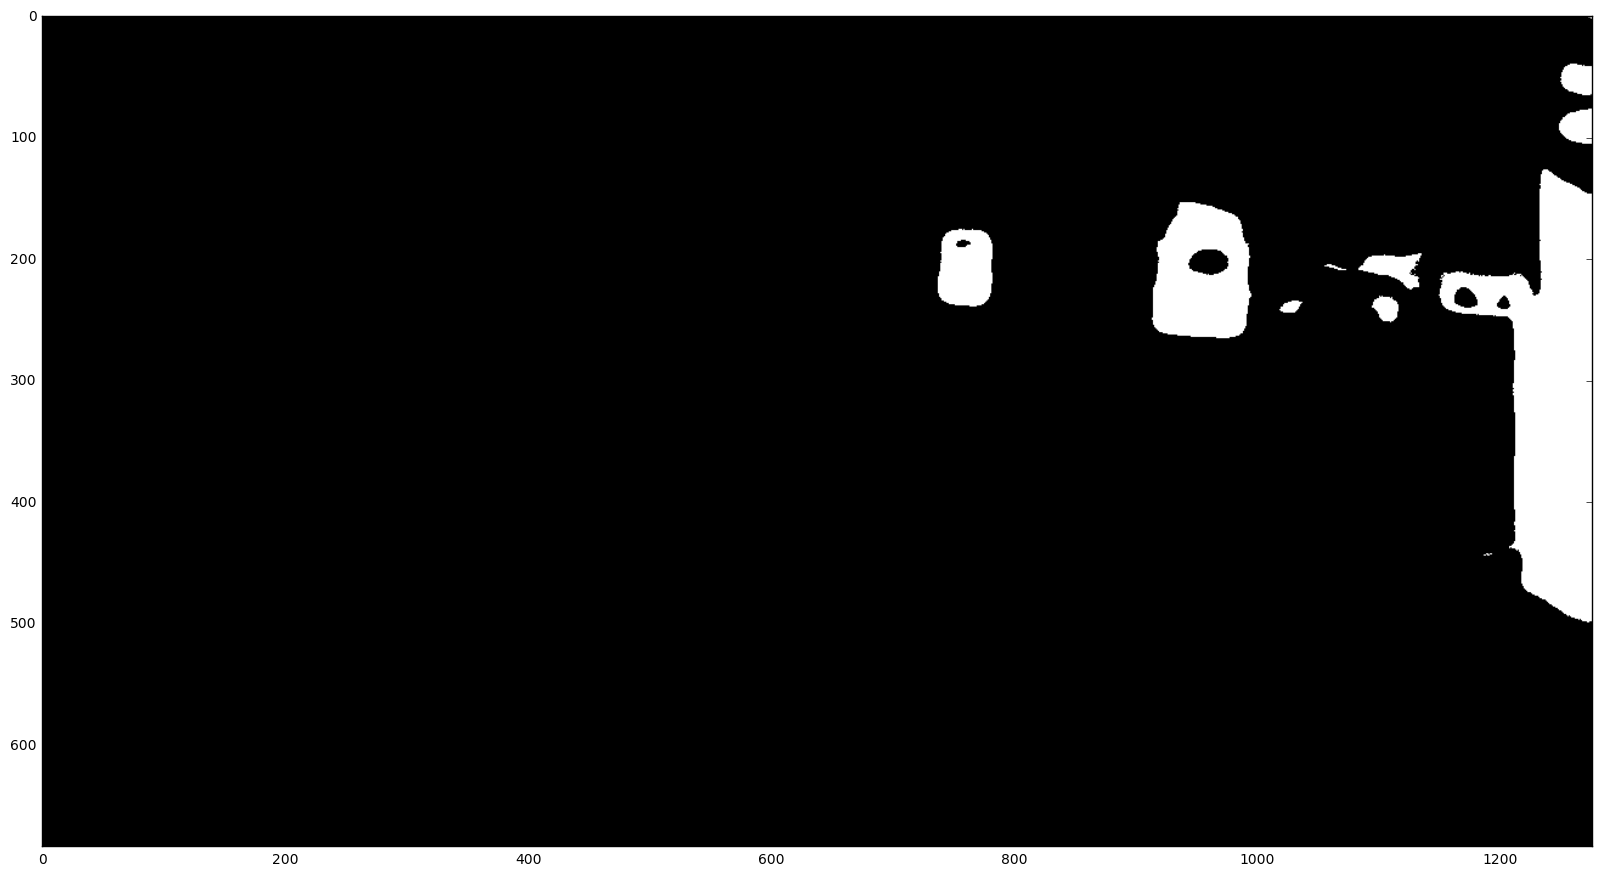

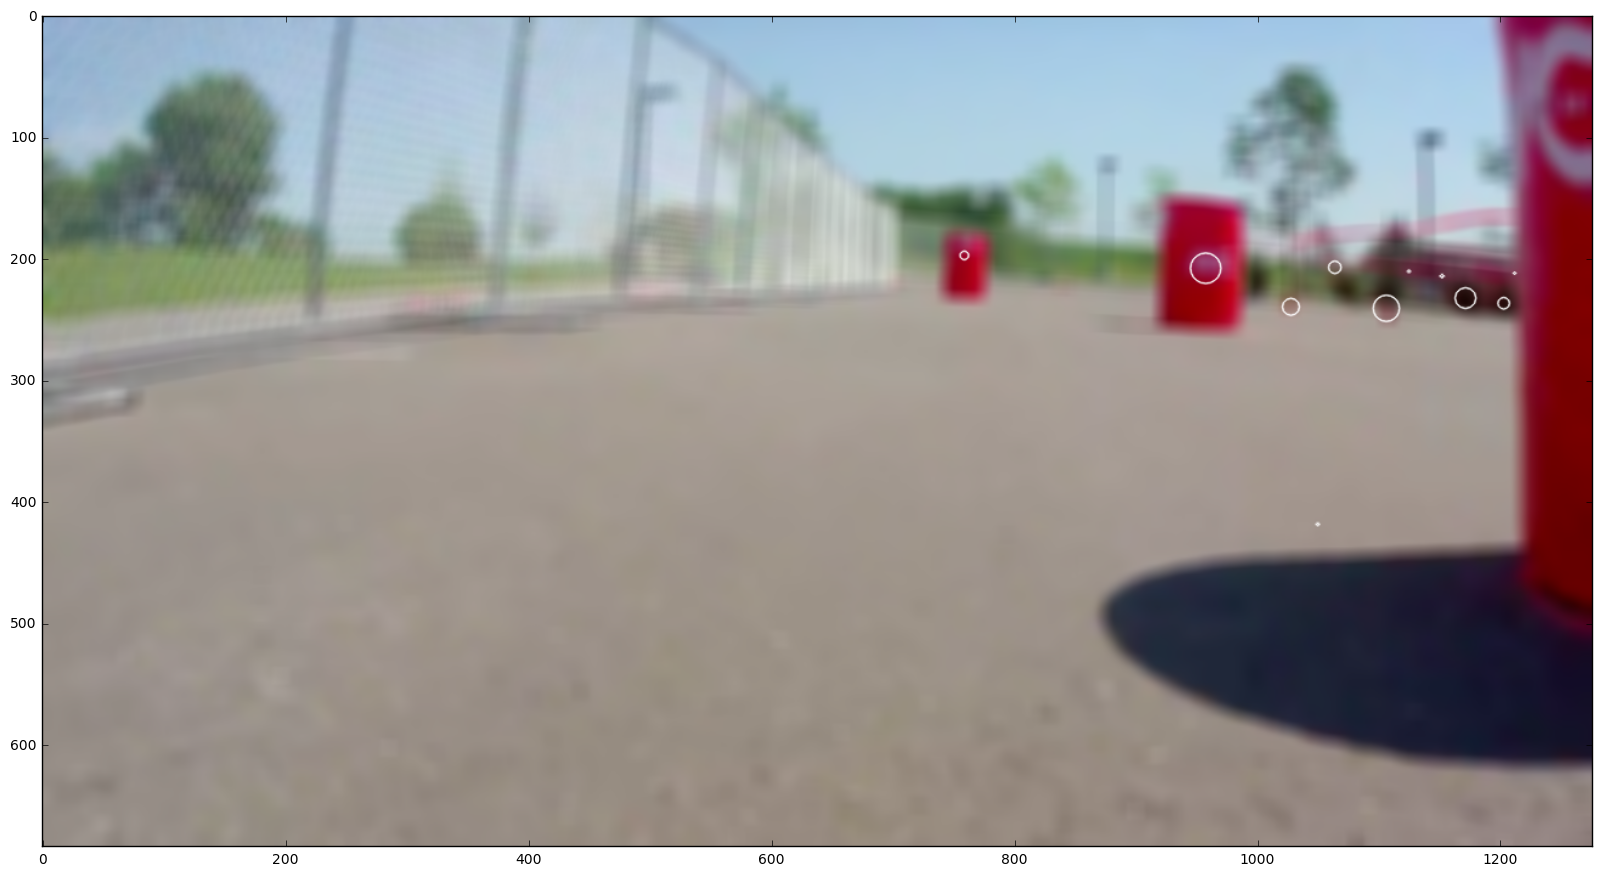

In [14]:
#cv2.SimpleBlobDetector_create
# Set up the detector with default parameters.
params = cv2.SimpleBlobDetector_Params()
params.minArea = 20*20
params.filterByArea = False
params.filterByCircularity = False
params.minCircularity = 0
params.maxCircularity = 1000
params.filterByColor = False
params.filterByConvexity = False
params.filterByInertia = False
params.maxArea = 300*3000
detector = cv2.SimpleBlobDetector_create(params)
 
# Detect blobs.
keypoints = detector.detect(im_mask)
im_blank = np.zeros_like(im)
 
horizon = vanishing_point_xy[1]
#keypoints = [k for k in keypoints if k.pt[1] < vanishing_point_xy[1]+30]
#keypoints = [k for k in keypoints if k.pt[1]+k.size/2. > vanishing_point_xy[1]]

# Draw detected blobs as circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (255,255,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


show(im_mask)
show(im_with_keypoints)

In [15]:
horizon


270

In [16]:
# top of barrel should be above horizon, bottom of barrel should be below horizon
# middle of barrel should be above horizon

In [17]:
len(keypoints)

11

In [18]:
for k in keypoints:
    print('angle', k.angle)
    print('class_id',k.class_id)
    print('octave', k.octave)
    print('pt',k.pt)
    print('response',k.response)
    print('size',k.size)
    print()

angle -1.0
class_id -1
octave 0
pt (1049.0596923828125, 418.6828918457031)
response 0.0
size 2.2360680103302

angle -1.0
class_id -1
octave 0
pt (1026.9765625, 239.68008422851562)
response 0.0
size 13.970318794250488

angle -1.0
class_id -1
octave 0
pt (1202.0924072265625, 236.7615509033203)
response 0.0
size 9.453629493713379

angle -1.0
class_id -1
octave 0
pt (1105.477294921875, 240.96194458007812)
response 0.0
size 21.54657745361328

angle -1.0
class_id -1
octave 0
pt (1170.6300048828125, 232.51376342773438)
response 0.0
size 17.14666175842285

angle -1.0
class_id -1
octave 0
pt (1151.302978515625, 214.3030242919922)
response 0.0
size 2.9554388523101807

angle -1.0
class_id -1
octave 0
pt (1124.0599365234375, 210.4633026123047)
response 0.0
size 2.0

angle -1.0
class_id -1
octave 0
pt (1211.0, 212.0)
response 0.0
size 2.0

angle -1.0
class_id -1
octave 0
pt (1063.0980224609375, 207.16993713378906)
response 0.0
size 10.28183650970459

angle -1.0
class_id -1
octave 0
pt (956.86853027

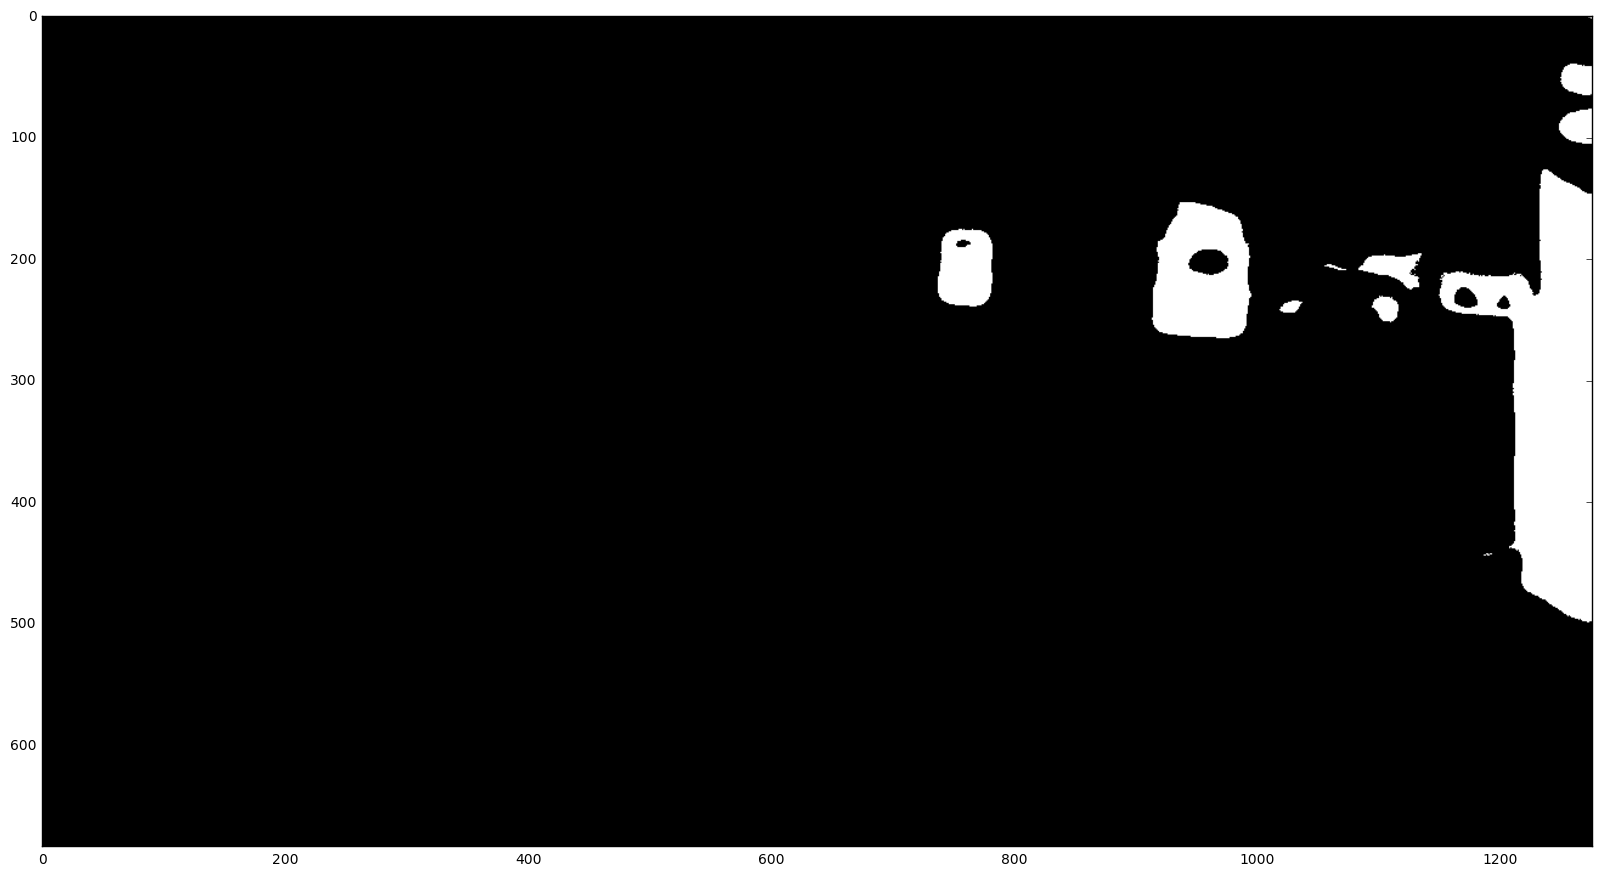

In [19]:
show(im_mask)

In [20]:
#im_dilated =cv2.dilate(im_mask,(180,180))
#im_eroded = cv2.erode(im_dilated,(180,180))
#show([im_eroded])
#im_mask = im_eroded

In [21]:
# see http://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
im_,contours,hierarchy = cv2.findContours(im_mask,cv2.RETR_TREE ,2)

In [22]:
def circularity(contour):
    perimeter = cv2.arcLength(contour, True)
    return 4 * math.pi * cv2.contourArea(contour) / (perimeter * perimeter)


In [23]:
def centroid(contour):
    M = cv2.moments(contour)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    return (cx, cy)
    

In [24]:
im_draw = im.copy()

In [25]:
for contour, i in zip(contours,range(len(contours))):
    hull = cv2.convexHull(contour,contour)
    contour = hull
    cv2.drawContours(im_draw,[contour],0,(0,0,255),2)
    area = cv2.contourArea(contour)
    if area < 20*20:
        continue
    print()
    print(i)
    print('len',len(contour))
    print('area',cv2.contourArea(contour))
    if(len(contour)>=5): 
        e = cv2.fitEllipse(contour)
        cv2.ellipse(im_draw, e, (255,255,155))
        print('Ellipse',e)
    if(len(contour)>1):
        print('circularity', circularity(contour))
        print(cv2.arcLength(contour,True))
        cv2.putText(im_draw,str(round(circularity(contour),2)),centroid(contour),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0))


    


2
len 6
area 866910.5
Ellipse ((636.7862548828125, 341.9682312011719), (1015.413330078125, 1714.257568359375), 90.06500244140625)
circularity 0.7137975553676426
3906.6502815485

14
len 15
area 1143.0
Ellipse ((1114.531005859375, 210.12889099121094), (34.03641891479492, 65.55255889892578), 87.36138916015625)
circularity 0.7195496704289064
141.28552114963531

15
len 28
area 2693.0
Ellipse ((759.561767578125, 207.70858764648438), (53.71519088745117, 70.6878433227539), 4.304675102233887)
circularity 0.9118345894916868
192.64825403690338

17
len 32
area 8027.0
Ellipse ((953.2438354492188, 214.7137908935547), (91.33577728271484, 125.54301452636719), 1.521489143371582)
circularity 0.8981059413066104
335.1334511041641

18
len 19
area 516.5
Ellipse ((959.4719848632812, 202.91152954101562), (20.937225341796875, 32.85200500488281), 86.86769104003906)
circularity 0.9031821377995737
84.77199912071228


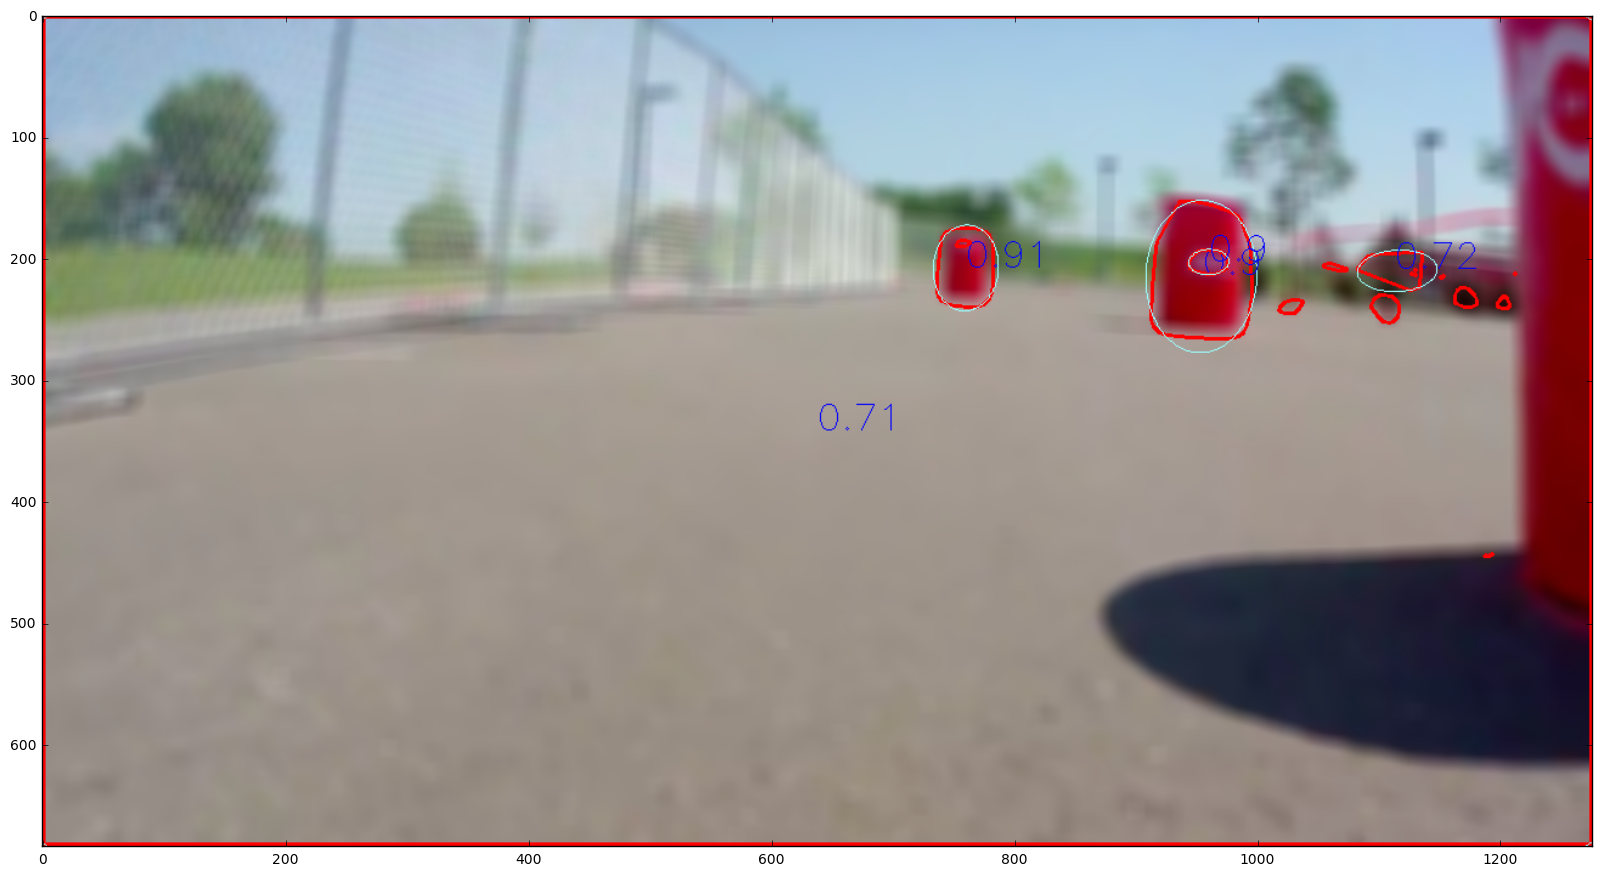

In [27]:
show(im_draw)